In [1]:
import lampe
import numpy as np
import torch
import zuko

import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.integrate as integrate

from IPython.display import display
import pickle
from typing import Tuple, Callable, List, Dict
from tqdm.notebook import tqdm_notebook as tqdm
from torch import Tensor

In [2]:
N = 100
theta_grid = np.linspace(-8, 8, 1000)
N_simu = 50_000
M = 100_000
warm_up_steps = 20_000
sigma = 0.01
tau = 0.25
rho = 1 / 2

In [3]:
def posterior_summaries(thetas: Tuple, x1: float, x2: float, sigma_2_y: float = 1):
    r"""Compute the true posterior of :math:`p(\theta | x)`.

    Args:
        thetas: points where we want the density function to be computed.
        x1: First dimension of the observation.
        x2: Second dimension of the observation.
        sigma_2_y (optional): Corruption. Defaults to 1 (no corruption).
    """

    def improper_posterior_summaries(theta, x1=x1, x2=x2):
        likelihood_x1_part = -N * np.square(theta - x1) / (2 * sigma_2_y**2)
        likelihood_x2_part = (
            -0.5 * np.square(sigma_2_y - x2) / (2 * np.square(sigma_2_y) / N)
        )
        prior_part = -np.square(theta) / 50
        return (
            np.exp(likelihood_x1_part) * np.exp(likelihood_x2_part) * np.exp(prior_part)
        )

    z_summaries, eps = integrate.quad(improper_posterior_summaries, -25, 25)
    return [
        improper_posterior_summaries(theta, x1, x2) / z_summaries for theta in thetas
    ]

In [4]:
def get_true_post(task_name: str, x_star: Tensor, sigma_y_2: float = 1) -> Tuple:
    r"""Get the true posterior of :math:`p(\theta | x^*)`.

    Args:
        task_name: Name of the task.
        x_star: Observation.
        sigma_y_2 (optional): Corruption. Defaults to 1 (no corruption).

    Returns:
        Tuple: Density evaluated at points theta_grid.
    """
    theta_grid  # Convert theta_grid to a torch tensor
    post = None
    if task_name == "Gaussian":
        # We observe x = (x1, x2) = (mean, var)
        post = posterior_summaries(theta_grid, x_star[0], x_star[1], sigma_y_2)
    # post = torch.stack(post).cuda()  # Move post to CUDA
    return post

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [6]:
class CS():
    
    def __init__(self, N_simu, miss_specification_param=0.75, N_obs=M) -> None:
        self.name = "CS"
        self.prior_c = torch.distributions.Uniform(low=200, high=1500)
        self.prior_p = torch.distributions.Uniform(low=3, high=20)
        self.prior_d = torch.distributions.Uniform(low=10, high=20)
        self.has_post = False
        rate_c_0, rate_p_0, rate_d_0 = self.prior_sample()
        self.theta0 = torch.tensor([rate_c_0, rate_p_0, rate_d_0])
        self.miss_specification_param = miss_specification_param
        
        self.features_dim = 4
        self.parameters_dim = 3
        self.data = self.simulate_data(N_simu)
        self.data_test = self.simulate_data(N_simu//10)
        self.true_obs_data = self.gen_obs(N_obs, self.theta0)
        self.y0 = self.true_obs_data["x"][0]
        
        self.y0_scaled = (self.y0 - self.data["scale_parameters"][0]) / self.data["scale_parameters"][1]
    
    def prior_sample(self, n=1):
        return self.prior_c.sample((n,)), self.prior_p.sample((n, )), self.prior_d.sample((n,))
                
    def simulate_data(self, N_simu, theta0=None, raw=False):
        simu_data = {"theta": [], "x": [], "cell_positions": [], "parent_positions": [], "cell_types": []}
        for _ in range(N_simu):
            if theta0 is not None:
                rate_c, rate_p, rate_d = theta0
            else:
                rate_c = self.prior_c.sample()
                rate_p = self.prior_p.sample()
                rate_d = self.prior_d.sample()

            N_c = int(torch.distributions.Poisson(rate=rate_c).sample().item())
            N_p = int(torch.distributions.Poisson(rate=rate_p).sample().item())
            N_d = torch.distributions.Poisson(rate=rate_d).sample((N_c,))  # Modifier cette ligne

            c = torch.distributions.Uniform(low=0, high=1).sample((N_c, 2))
            p = torch.distributions.Uniform(low=0, high=1).sample((N_p, 2))

            cell_types = torch.zeros(N_c, dtype=torch.bool)
            for parent_idx in range(N_p):
                parent = p[parent_idx]

                num_daughters = int(N_d[parent_idx].item())
                num_available_daughters = c.shape[0]

                if num_daughters > num_available_daughters:
                    num_daughters = num_available_daughters

                _, daughters_idx = torch.topk(torch.cdist(c, parent.unsqueeze(0), p=2).squeeze(), num_daughters, largest=False)
                daughters = c[daughters_idx]
                r = torch.cdist(daughters, parent.unsqueeze_(0), p=2).max().item() if daughters.numel() !=0 else 0

                distances = torch.cdist(c, parent.unsqueeze(0), p=2).squeeze()
                cell_types[distances <= r] = 1
                

                # Calculate summary statistics
            n_cancer_cells = torch.sum(cell_types).item()
            n_stromal_cells = N_c - n_cancer_cells
            stromal_cells = c[cell_types == 0]
            cancer_cells = c[cell_types == 1]
            if len(stromal_cells) > 0 and len(cancer_cells) > 0:
                min_distances = torch.cdist(stromal_cells, cancer_cells, p=2).min(dim=1).values
                mean_min_dist = torch.mean(min_distances).item()
                max_min_dist = torch.max(min_distances).item()
            else:
                mean_min_dist = float('inf')
                max_min_dist = float('inf')
            theta = torch.tensor([rate_c, rate_p, rate_d])
            x = torch.tensor([n_cancer_cells, n_stromal_cells, mean_min_dist, max_min_dist])
            simu_data["theta"].append(theta)
            simu_data["x"].append(x)
            simu_data["cell_positions"].append(c)
            simu_data["parent_positions"].append(p)
            simu_data["cell_types"].append(cell_types)

        simu_data["theta"] = torch.stack(simu_data["theta"])
        simu_data["x"] = torch.stack(simu_data["x"])
        scale_mean, scale_std = simu_data["x"].mean(0), simu_data["x"].std(0)
        simu_data["scale_parameters"] = scale_mean, scale_std
        simu_data["scaled_x"] = (simu_data["x"] - scale_mean) / scale_std

        return simu_data
    
    def gen_obs(self, N_obs, theta0):
        obs_data = {"theta": [], "x": [], "cell_positions": [], "parent_positions": [], "cell_types": [], "cell_positions_raw": [],"cell_types_raw": []}

        for _ in range(N_obs):
            if theta0 is not None:
                rate_c, rate_p, rate_d = theta0
            else:
                rate_c = self.prior_c.sample()
                rate_p = self.prior_p.sample()
                rate_d = self.prior_d.sample()

            N_c = int(torch.distributions.Poisson(rate=rate_c).sample().item())
            N_p = int(torch.distributions.Poisson(rate=rate_p).sample().item())
            N_d = torch.distributions.Poisson(rate=rate_d).sample((N_p,))

            c = torch.distributions.Uniform(low=0, high=1).sample((N_c, 2))
            p = torch.distributions.Uniform(low=0, high=1).sample((N_p, 2))

            cell_types = torch.zeros(N_c, dtype=torch.bool)
            for parent_idx in range(N_p):
                parent = p[parent_idx]

                num_daughters = int(N_d[parent_idx].item())
                num_available_daughters = c.shape[0]

                if num_daughters > num_available_daughters:
                    num_daughters = num_available_daughters

                _, daughters_idx = torch.topk(torch.cdist(c, parent.unsqueeze(0), p=2).squeeze(), num_daughters, largest=False)
                daughters = c[daughters_idx]

                r = torch.cdist(daughters, parent.unsqueeze_(0), p=2).max().item() if daughters.numel() != 0 else 0
                
                distances = torch.cdist(c, parent.unsqueeze(0), p=2).squeeze()

                cell_types[distances <= r] = 1
                obs_data["cell_positions_raw"].append(c)
                obs_data["cell_types_raw"].append(cell_types)
            
            if torch.distributions.Bernoulli(self.miss_specification_param).sample():
                removal_radius = r * 0.8
                
                
                if cell_types.shape == distances.shape:  # Check if the mask shape matches cell_types shape
                    mask = (cell_types == 1) & (distances <= removal_radius)
                    c = c[~mask]
                    cell_types = cell_types[~mask]

                

        # Calculate summary statistics
            n_cancer_cells = torch.sum(cell_types).item()
            n_stromal_cells = N_c - n_cancer_cells
            stromal_cells = c[cell_types == 0]
            cancer_cells = c[cell_types == 1]
            if len(stromal_cells) > 0 and len(cancer_cells) > 0:
                min_distances = torch.cdist(stromal_cells, cancer_cells, p=2).min(dim=1).values
                mean_min_dist = torch.mean(min_distances).item()
                max_min_dist = torch.max(min_distances).item()
            else:
                mean_min_dist = float('inf')
                max_min_dist = float('inf')
            theta = torch.tensor([rate_c, rate_p, rate_d])
            x = torch.tensor([n_cancer_cells, n_stromal_cells, mean_min_dist, max_min_dist])
            obs_data["theta"].append(theta)
            obs_data["x"].append(x)
            obs_data["cell_positions"].append(c)
            obs_data["parent_positions"].append(p)
            obs_data["cell_types"].append(cell_types)

        obs_data["theta"] = torch.stack(obs_data["theta"])
        obs_data["x"] = torch.stack(obs_data["x"])
        
        scale_mean, scale_std = obs_data["x"].mean(0), obs_data["x"].std(0)
        obs_data["scale_parameters"] = scale_mean, scale_std
        obs_data["scaled_x"] = (obs_data["x"] - scale_mean) / scale_std

        return obs_data

                
        

In [7]:
class Gaussian:
    r"""Gaussian Task.
        - Simulation: :math:`z_i \sim \mathcal{N}(\theta, 1), i=1,...N_simu`
        - TDGP: :math:`z_i \sim \mathcal{N}(\theta, \sigma^2), i=1,...N_simu`
        - Feature space: Summary statistic :math:`x=\left(mean(z_1,...z_{N_simu}); var(z_1,...z_{N_simu)\right)`
    NB: We can see the TDGP such that :math:`y = x + \epsiolon, x \sim \mathcal{M}(\theta), \epsilon \sim \mathcal{N}(0, \sigma_y^2).
    """

    def __init__(
        self, N_simu: int, sigma_y_2: float, true_theta: Tensor = torch.zeros(1)
    ) -> None:
        r"""Init the object, including datasets.

        Args:
            N_simu: total number of simulations
            sigma_y_2: Corruption, Var of the observed data.
        """
        self.name = "Gaussian"
        self.prior = torch.distributions.Normal(0, 5)
        self.sigma_y_2 = sigma_y_2
        self.features_dim = 2
        self.parameters_dim = 1
        self.true_theta = true_theta
        self.has_post = True
        data = self.generate_data(N_simu, sigma_y_2)
        data_test = self.generate_data(N_simu // 10, sigma_y_2)
        true_obs_data = self.generate_data(1, sigma_y_2, true_theta)

        x0 = true_obs_data["x"]
        y0 = x0 + true_obs_data["eps"]
        x0_scaled = (x0 - data["scale_parameters"][0]) / data["scale_parameters"][1]
        y0_scaled = (y0 - data["scale_parameters"][0]) / data["scale_parameters"][1]

        self.data = data
        self.data_test = data_test
        self.x0 = x0.squeeze()
        self.y0 = y0.squeeze()
        self.x0_scaled = x0_scaled
        self.y0_scaled = y0_scaled.squeeze()

    def prior_sample(self, n):
        return self.prior.sample((n,1))

    def generate_data(self, N: int, sigma_y_2: float = 1, thetas: Tensor = None):
        """Generates data according to #TODO Maths ici

        Args:
            N: Total number of simulations
            sigma_y_2 (optional): Corruption. Defaults to 1.
            theta (optional): Reference theta.

        Returns:
            res: dictionnary whose entries are parameters thetas, the raw simulations x, the corruption espilons as well as the scaled observations and the scale parameters.
        """
        if thetas is None:
            thetas = self.prior_sample(N)
        sigma_eps = (
            sigma_y_2 - 1
        )  # If the TDGP has a variance of \sigma^2, the corruption layer has \sigma-1
        res = {}
        res["theta"] = thetas
        means_and_vars = torch.zeros((N, 2), device=device)

        for i, theta in enumerate(thetas):
            z = torch.distributions.Normal(theta, 1).sample((100,)).to(device)
            mean = z.mean()
            var = z.var()
            means_and_vars[i] = torch.stack(
                [mean.unsqueeze_(0), var.unsqueeze_(0)]
            ).squeeze_()

        res["x"] = means_and_vars

        norm_max = -1
        for n_run in range(1):
            # We take the run where the corruption has more effect, to be able to compare.
            eps = (
                torch.distributions.Normal(
                    torch.zeros_like(res["x"]), np.sqrt(sigma_eps)
                )
                .sample()
                .to(device)
            )
            if torch.norm(eps) > norm_max:
                epsilons = eps
                norm_max = torch.norm(eps)
        res["eps"] = epsilons
        scale_mean, scale_std = res["x"].mean(0), res["x"].std(0)
        res["scale_parameters"] = scale_mean, scale_std
        res["scaled_x"] = (res["x"] - scale_mean) / scale_std
        return res

    def true_post(self, x_star: Tensor, sigma_2_y: float = None) -> Tuple:
        """Get the true posterior given an observation x_star.

        Args:
            x_star: An observation.
            sigma_2_y (optional): Corruption. Defaults to None.

        Returns:
            post: Posterior density evaluated from -8 to 8.
        """
        if sigma_2_y is None:
            sigma_2_y = self.sigma_y_2
        theta_grid_t = np.linspace(-8, 8, 1000)
        post = posterior_summaries(theta_grid_t, x_star[0], x_star[1], sigma_2_y)
        return post

In [8]:
sigma_2_y = 2

In [9]:
def build_nsf(features, context):
    """Callable to instantiate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5).to(device)


def train_flow(
    flow: lampe.inference.NPE,
    loss: Callable[[Tensor, Tensor], float],
    theta: Tensor,
    x: Tensor,
    theta_test: Tensor,
    x_test: Tensor,
) -> lampe.inference.NPE:
    """Training procedure for the instantiated NPE.

    Args:
        flow (lampe.inference.NPE): Flow object to be trained.
        loss (Callable[[Tensor, Tensor], float]): Loss function used for training.
        theta (Tensor): Parameters.
        x (Tensor): Observations.
        theta_test (Tensor): Parameters used for early stopping.
        x_test (Tensor): Observations used for early stopping.

    Returns:
        lampe.inference.NPE: The trained flow.
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    #theta_test = theta_test.unsqueeze(-1).to(device)
    data = lampe.data.JointDataset(theta.to(device), x.to(device))
    loader = lampe.data.DataLoader(data, batch_size=256)
    with torch.no_grad():
        min_loss = loss(theta_test, x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar

    flow.train()

    for epoch in range(50):
        for theta_batch, x_batch in loader:
            theta_batch = theta_batch#.unsqueeze(-1).to(device)
            x_batch = x_batch.to(device)
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if (
                len(min_loss_list) - np.argmin(min_loss_list) > 5
            ):  # No improvement in loss(test) for the last 5 iterations
                # Early stop
                break
    flow.eval()
    return flow


def create_train_flow(task) -> lampe.inference.NPE:
    """Creates a conditional flow (NSF) and trains it on the task data.

    Args:
        task: A task object.

    Returns:
        lampe.inference.NPE: The trained flow.
    """
    data = task.data
    data_test = task.data_test
    theta = data["theta"]
    theta_test = data_test["theta"]
    flow = lampe.inference.NPE(
        theta_dim=task.parameters_dim, x_dim=task.features_dim, build=build_nsf
    ).to(device)
    loss = lampe.inference.NPELoss(flow).to(device)
    x = data["scaled_x"].to(device)
    x_test = data_test["scaled_x"].to(device)
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    return flow


task = Gaussian(N_simu=N_simu, sigma_y_2=sigma_2_y)
#task = CS(N_simu, N_obs=10_000)

q_NPE = create_train_flow(task)

In [10]:
def train_unconditional_flow(
    flow: zuko.flows, loss: Callable[[Tensor], float], x: Tensor, x_test: Tensor
) -> zuko.flows:
    """Trains a unconditional flow on x.

    Args:
        flow: Object flow to be trained.
        loss: Method to compute a loss.
        x: Training data.
        x_test: Test data, used for early stopping.

    Returns:
        flow: Trained flow object.
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
    loader = torch.utils.data.DataLoader(x.to(device), 256)

    with torch.no_grad():
        min_loss = loss(x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar

    flow.train()

    for epoch in range(50):
        for x_batch in loader:
            x_batch = x_batch.to(device)
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if (
                len(min_loss_list) - np.argmin(min_loss_list) > 5
            ):  # No improvement in loss(test) for the last 5 iterations
                # Early stop

                break
    flow.eval()
    return flow


def create_train_unconditional_flow(task) -> zuko.flows:
    """Instanciate and trains an unconditional flow (MAF) on the task data.

    Args:
        task: A task, containing train and test data.

    Returns:
        flow: The trained flow.
    """
    data = task.data
    data_test = task.data_test
    flow = zuko.flows.NAF(features=task.features_dim, context=0).to(device)  #!
    loss = lambda x: -flow().log_prob(x).mean()
    x = data["scaled_x"].to(device)
    x_test = data_test["scaled_x"].to(device)
    flow = train_unconditional_flow(flow, loss, x, x_test)
    return flow

q_x_NF = create_train_unconditional_flow(task)

IndexError: index 1 is out of bounds for dimension 1 with size 1

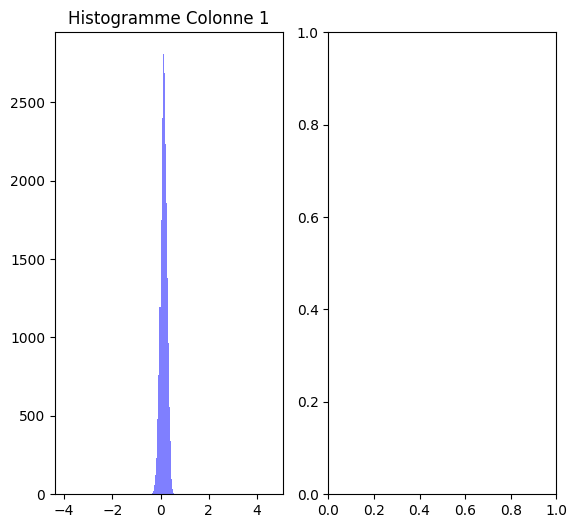

In [11]:

    
npe_samples_y = q_NPE.flow(task.y0_scaled).sample((20_000,))

    
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.hist(npe_samples_y[:, 0], bins=200, color='blue', alpha=0.5)
plt.title('Histogramme Colonne 1')

plt.subplot(1, 3, 2)
plt.hist(npe_samples_y[:, 1], bins=200, color='green', alpha=0.5)
plt.title('Histogramme Colonne 2')

plt.subplot(1, 3, 3)
plt.hist(npe_samples_y[:, 2], bins=200, color='red', alpha=0.5)
plt.title('Histogramme Colonne 3')

plt.tight_layout()
plt.show()

In [12]:
# Define the proposal function
proposal_data = q_x_NF().sample((M+warm_up_steps,))
def proposal(x_curr):
    idx = torch.randint(M+warm_up_steps,(1,))
    return proposal_data[idx]
    #return x_curr + torch.distributions.Normal(0, 1).sample(x_curr.shape).to(device)


# Define the f function
def f(y0, x, rho, sigma, tau, q_x_NF):
    D = x.shape[-1]
    res = torch.zeros_like(x)
    for j in range(D):
        xj = x[:, j]
        yj = y0[j]
        zj = torch.distributions.Bernoulli(rho).sample().to(device)
        if not zj:
            spike_dist = torch.distributions.Normal(
                xj.detach(), torch.tensor(sigma).to(device)
            )
            res[:, j] = torch.exp(spike_dist.log_prob(yj))
        else:
            slab_dist = torch.distributions.Cauchy(
                xj.detach(), torch.tensor(tau).to(device)
            )
            res[:, j] = torch.exp(slab_dist.log_prob(yj))
    return res * torch.exp(q_x_NF().log_prob(x))


def mcmc(x0, warm_up_steps, M, y0, rho, sigma, tau, q_x_NF):
    x_curr = x0.to(device)
    my_samples = torch.empty((warm_up_steps + M, x0.shape[1])).to(device)
    log_f_x_curr = f(y0, x_curr, rho, sigma, tau, q_x_NF).log()

    for i in tqdm(range(warm_up_steps + M), desc="MCMC sampling"):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star, rho, sigma, tau, q_x_NF).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

        u = torch.FloatTensor(a.shape).uniform_().to(device)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)

        #  my_samples[i] = x_curr
        my_samples[i] = x_curr

    my_samples = my_samples[warm_up_steps:]
    # my_samples = torch.stack(my_samples)
    return my_samples

In [13]:
class MyMCMC():
    r"""Class to sample from the posterior :math: `p(\theta \mid y)`"""
    
    def __init__(self, y0: Tensor, tau: float, sigma: float, rho: float, q_x_NF: zuko.flows) -> None:
        
        self.y0 = y0
        self.tau = tau
        self.sigma = sigma
        self.rho = rho
        self.q_x_NF = q_x_NF
    
    def f_density(self, y0: Tensor, x: Tensor) -> Tensor:
        #print(x.shape)
        D = x.shape[-1]
        res = torch.zeros_like(x)
        for j in range(D):
            xj = x[:, j]
            yj = y0[j]
            zj = torch.distributions.Bernoulli(rho).sample().to(device)
            if not zj:
                spike_dist = torch.distributions.Normal(
                    xj.detach(), torch.tensor(sigma).to(device)
                )
                res[:, j] = torch.exp(spike_dist.log_prob(yj))
            else:
                slab_dist = torch.distributions.Cauchy(
                    xj.detach(), torch.tensor(tau).to(device)
                )
                res[:, j] = torch.exp(slab_dist.log_prob(yj))
        return res #* torch.exp(q_x_NF().log_prob(x))[:,None]
    
    def proposal(self, M: int, warm_up_steps: int, proposal_data: Tensor) -> Tensor:
        idx = torch.randint(M+warm_up_steps,(1,))
        return proposal_data[idx]

    def sample(self, M: int, warm_up_steps: int, features_dim: int) -> Tensor:
        f_lampe = lambda x: self.f_density(self.y0, x)
        n_chains= 4
        x_curr = torch.FloatTensor(n_chains,features_dim).uniform_(-1,1).to(device)
        my_samples = torch.empty((n_chains,warm_up_steps + M//n_chains, x_curr.shape[1])).to(device)
        log_f_x_curr = f_lampe(x_curr).log()
        
        proposal_data = self.q_x_NF().sample((M+warm_up_steps,))
        with torch.no_grad():
            
            for i in range(int(warm_up_steps + M//n_chains)):
                x_star = self.proposal(M, warm_up_steps, proposal_data)
                log_f_x_star = f_lampe(x_star).log()
                log_a = log_f_x_star - log_f_x_curr
                a = torch.exp(log_a)
                u = torch.FloatTensor(a.shape).uniform_().to(device)
                mask = u < a
                x_curr = torch.where(mask, x_star, x_curr)
                log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)
                my_samples[:,i] = x_curr
            my_samples = my_samples[:,warm_up_steps:,:]
            samples_mcmc = my_samples#[:,:M//n_chains,:]

            samples_mcmc_ = samples_mcmc.reshape(1,M,x_curr.shape[-1]).squeeze()
        return samples_mcmc_

In [ ]:
test = MyMCMC(task.y0, tau, sigma, rho, q_x_NF)
test.sample(100,10,task.features_dim).shape

torch.Size([100, 2])

In [ ]:
test_xm = MyMCMC(task.y0_scaled.squeeze(), tau, sigma, rho, q_x_NF)
xm = test_xm.sample(M,warm_up_steps, task.features_dim)

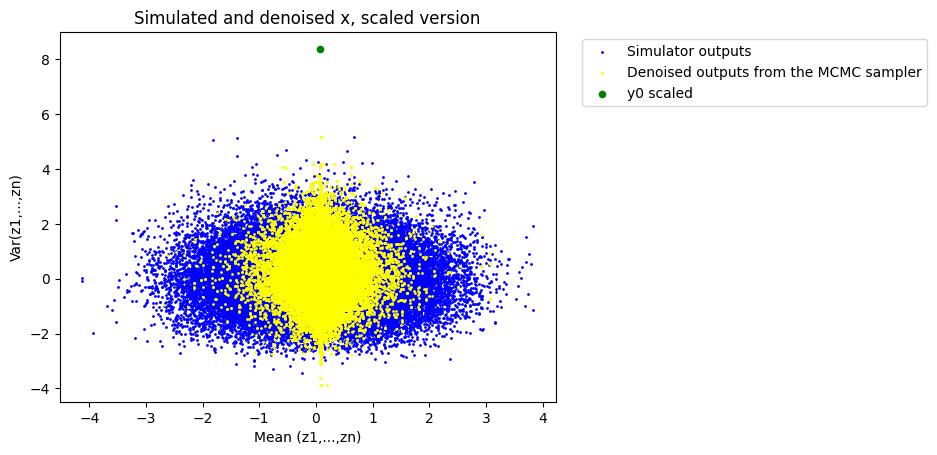

In [ ]:
fig, ax = plt.subplots()

ax.scatter(
    x=task.data["scaled_x"][:, 0].cpu(),
    y=task.data["scaled_x"][:, 1].cpu(),
    color="blue",
    label="Simulator outputs",
    s=1,
)
ax.scatter(
    x=xm[:, 0].cpu(),
    y=xm[:, 1].cpu(),
    label="Denoised outputs from the MCMC sampler",
    color="yellow",
    s=1,
)
ax.scatter(
    x=task.y0_scaled.cpu()[ 0],
    y=task.y0_scaled.cpu()[ 1],
    label="y0 scaled",
    color="green",
    s=20,
)
ax.set_xlabel("Mean (z1,...,zn)")
ax.set_ylabel("Var(z1,...,zn)")
ax.set_title("Simulated and denoised x, scaled version")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [ ]:
task.y0_scaled.squeeze()[0]

tensor(0.0793)

In [ ]:
rnpe_samples = q_NPE.flow(xm).sample()

In [ ]:
true_post_y = posterior_summaries(
    theta_grid,
    task.y0.cpu().squeeze()[0].item(),
    task.y0.cpu().squeeze()[1].item(),
    sigma_2_y,
)

In [ ]:
npe_samples = q_NPE.flow(task.y0_scaled).sample((20_000,))
true_post = task.true_post(task.y0.squeeze().cpu().numpy(), sigma_2_y)

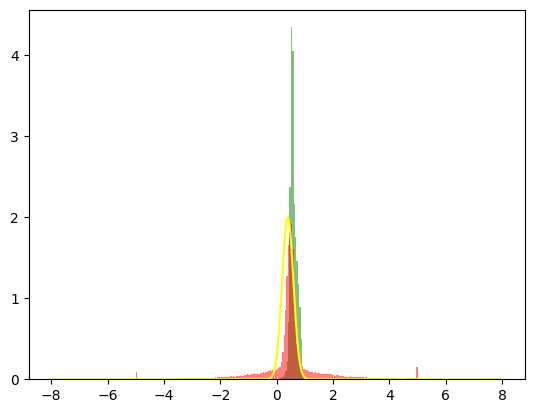

In [ ]:
plt.hist(
    npe_samples.squeeze().cpu(),
    bins=200,
    density=True,
    color="green",
    alpha=0.5,
    label="NPE samples q(θ|y0)",
)
plt.hist(
    rnpe_samples.squeeze().cpu(),
    bins=200,
    density=True,
    color="red",
    alpha=0.5,
    label="RNPE samples q(θ|y0)",
)
plt.plot(theta_grid, true_post_y, color="yellow", label=" p(θ|y0) under the true DGP")
#plt.xlim(2,4)

In [14]:
def rbf_kernel(x: Tensor, y: Tensor, gamma: float):
    r"""Computes the Radial Basis Function (RBF) Kernel, :math:`K(x,y) = \left(- \frac{\lVert x - y \rVert^2}{2\sigma^2} \right)`

    Args:
        x: Samples from population 1.
        y: Samples from population 2.
        gamma: Bandwidth.

    Returns:
        K(x, y)
    """
    
    pairwise_distance_squared = torch.square(torch.norm(x-y,dim=1)).squeeze()
    return torch.exp(-gamma * pairwise_distance_squared)

In [57]:
def mmd_two_samples(x: Tensor, y: Tensor, n_rep): #!Voir taille tenseur et adapter selon, ça pb pour CS ?
    r"""Computes once the MMD for 2 samples #TODO ref
    Args:
        x: Samples from population 1.
        y: Sampples from population 2.

    Returns:
        _type_: _description_
    """
    perms_x = x[torch.randint(high=x.shape[0], size=(n_rep, 10_000)),:]
    perms_y = y[torch.randint(high=y.shape[0], size=(n_rep, 10_000)),:]
    

    sigma2 = abs(torch.norm(perms_x- perms_y, dim=1)**2).max()
    gamma = 1 / (2 * sigma2)
    xx = rbf_kernel(perms_x, perms_x, gamma.item()) #! Lui aussi 
    yy = rbf_kernel(perms_y, perms_y, gamma.item())
    xy = rbf_kernel(perms_x, perms_y, gamma.item())
    return torch.tensor(xx.mean(-1) + yy.mean(-1) -2* xy.mean(-1))


def MMD(x: Tensor, y: Tensor, n_rep: int = 1_000) -> Tuple[Tensor, bool]:
    """Computes the MMD between two samples x,y, use permutation trick to check whether the value can be considered to be 0.

    H0= << t0 > t_{1-alhpa}.

    Args:
        x: Samples from population 1.
        y: Samples from population 2.
        n_rep: Number of repetition.

    Returns:
        t0, h0: Value of the MMD and wether or not H0 is accepted.
    """
    
    if x.shape[0] != y.shape[0]:
        min_rows = min(x.shape[0], y.shape[0])
        #x = x[torch.randperm(x.shape[0])][:min_rows]
        #y = y[torch.randperm(y.shape[0])][:min_rows]
        
    t0 = mmd_two_samples(x, y,1)
    t = mmd_two_samples(x, y, n_rep) 
    t.sort()
    h0 = torch.searchsorted(t, t0) <= 989  # If Ho accepted or not
    return t0, h0

In [16]:
def compute_rnpe_npe(
    task_name: str, sigma_2: float
) -> Tuple[Tensor, Tensor, Tuple, Tensor]:
    """General pipeline to compute both NPE and RNPE samples for a given task and corruption.

    Args:
        task_name: Name of the task.
        sigma_2: Corruption.

    Returns:
        Tuple[Tensor, Tensor, Tuple, Tensor]: NPE samples given x, y, theroritical given y and RNPE samples given y.
    """

    n_runs = 2
    task_l = []
    xm_l = []
    norm_npe_rnpe = []
    npe_samples_y_l = []
    theoritical_post_y_l = []
    rnpe_samples_l = []

    for _ in tqdm(range(n_runs), leave=True):
        task = Gaussian(
            N_simu=N_simu, sigma_y_2=sigma_2
        ) if task_name == "Gaussian" else CS(N_simu=N_simu, miss_specification_param=sigma_2)
        q_NPE = create_train_flow(task)
        q_x_NF = create_train_unconditional_flow(task)
        with torch.no_grad():
            mcmc_sampler = MyMCMC(task.y0_scaled.squeeze(), tau, sigma, rho, q_x_NF)
            xm = mcmc_sampler.sample(M, warm_up_steps, task.features_dim)

        npe_samples_y = q_NPE.flow(task.y0_scaled).sample((M,))
        theoritical_post_y = task.true_post(task.y0.squeeze().cpu().numpy(), sigma_2) if task.has_post else []
        rnpe_samples = q_NPE.flow(xm).sample()
        norm_npe_rnpe.append(npe_samples_y.mean() - rnpe_samples.mean())

        task_l.append(task)
        xm_l.append(xm)
        npe_samples_y_l.append(npe_samples_y)
        theoritical_post_y_l.append(theoritical_post_y)
        rnpe_samples_l.append(rnpe_samples)
    return {
        "task_l": task_l,
        "npe_samples_y_l": npe_samples_y_l,
        "theoritical_post_y_l": theoritical_post_y_l,
        "rnpe_samples_l": rnpe_samples_l,
        "xm_l": xm_l,
    }

In [92]:
def compute_metrics(
    task_l: List,
    npe_samples_x_l, #! Legacy
    npe_samples_y_l: List,
    theoritical_post_y_l: List,
    rnpe_samples_l: List,
    xm_l: List,
) -> Dict:
    npe_mmd_t0_l, npe_mmd_h0_l, rnpe_mmd_t0_l, rnpe_mmd_h0_l, norm_npe_rnpe = (
        [],
        [],
        [],
        [],
        [],
    )
    # Computiing MMD
    for i in range(len(xm_l)):
        xm_rescaled = (xm_l[i] + task_l[i].data["scale_parameters"][0]) * task_l[
            i
        ].data["scale_parameters"][1]
        npe_mmd_t0, npe_mmd_h0 = MMD(
            task_l[i].data["x"], task_l[i].y0.expand(40_000, -1)
        )
        rnpe_mmd_t0, rnpe_mmd_h0 = MMD(xm_rescaled, task_l[i].y0.expand(40_000, -1))

        npe_mmd_t0_l.append(npe_mmd_t0)
        npe_mmd_h0_l.append(npe_mmd_h0)
        rnpe_mmd_t0_l.append(rnpe_mmd_t0)
        rnpe_mmd_h0_l.append(rnpe_mmd_h0)

        norm_npe_rnpe.append(npe_samples_y_l[i].mean() - rnpe_samples_l[i].mean() + np.log(npe_samples_y_l[i].std()/rnpe_samples_l[i].std()))

    imax = np.argmax(norm_npe_rnpe)
    npe_samples_y = npe_samples_y_l[imax]
    theoritical_post_y = theoritical_post_y_l[imax]
    rnpe_samples = rnpe_samples_l[imax]
    rnpe_mmd_t0 = np.mean(rnpe_mmd_t0_l)
    rnpe_mmd_h0 = torch.sum(rnpe_mmd_h0).item() > torch.sum(~rnpe_mmd_h0).item()
    npe_mmd_t0 = np.mean(npe_mmd_t0_l)
    npe_mmd_h0 = torch.sum(npe_mmd_h0).item() > torch.sum(~npe_mmd_h0).item()

    return {
        "npe_samples_y": npe_samples_y,
        "theoritical_post_y": theoritical_post_y,
        "rnpe_samples": rnpe_samples,
        "rnpe_mmd_t0": rnpe_mmd_t0,
        "rnpe_mmd_h0": rnpe_mmd_h0,
        "npe_mmd_t0": npe_mmd_t0,
        "npe_mmd_h0": npe_mmd_h0,
    }

In [50]:
donnees = {}
sigmas_2 = np.arange(1, 2, 1)
sigmas_2 = [0.75, 0.50]
with tqdm(sigmas_2, unit="Sigma²", desc="Corruption") as tq:
    for sigma_2 in tq:
        print(sigma_2)
        donnees[sigma_2] = compute_rnpe_npe("CS", sigma_2)

Corruption:   0%|          | 0/2 [00:00<?, ?Sigma²/s]

0.75


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
with open("CS_test", "wb") as f:
    pickle.dump(donnees, f)

In [87]:
with open("donnees_mcmc_upgrade","rb") as f:
    donnees = pickle.load(f)

In [93]:
results = {}
with tqdm(donnees.keys(), unit="Sigma²", desc="Corruption") as tq:
    for sigma_2 in tq:
        print(sigma_2)
        results[sigma_2] = compute_metrics(**donnees[sigma_2])

Corruption:   0%|          | 0/6 [00:00<?, ?Sigma²/s]

1.0


C:\Users\mmmat\AppData\Local\Temp\ipykernel_12792\2009030885.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(xx.mean(-1) + yy.mean(-1) -2* xy.mean(-1))


1.5
2.0
2.5
3.0
3.5


In [89]:
@widgets.interact(sigma_2=donnees.keys())
def plot_posteriors_widget(sigma_2=1):
    plt.close()
    fig, ax = plt.subplots()
    ax.hist(
        results[sigma_2]["npe_samples_y"].squeeze(),
        bins=400,
        color="green",
        density=True,
        label="Posterior samples from NPE",
        alpha=0.5,
    )
    ax.hist(
        results[sigma_2]["rnpe_samples"].squeeze(),
        bins=400,
        color="red",
        density=True,
        label="Posterior samples from RNPE",
        alpha=0.5,
    )
    ax.plot(theta_grid, results[sigma_2]["theoritical_post_y"])
    ax.legend()
    ax.set_title(f"NPE and RNPE samples, sigma_y² = {sigma_2}")
    plt.show()

interactive(children=(Dropdown(description='sigma_2', options=(1.0, 1.5, 2.0, 2.5, 3.0, 3.5), value=1.0), Outp…

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


False
False
False
False
False
False


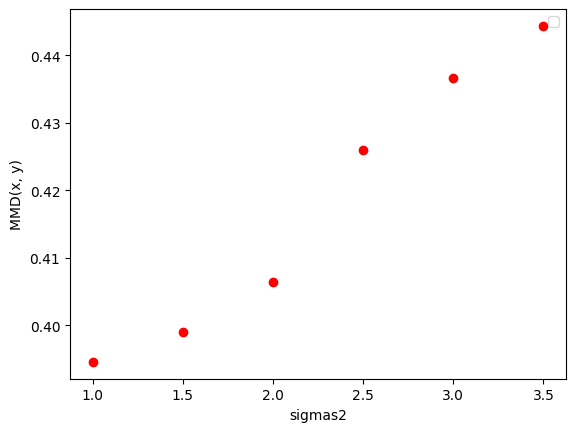

In [94]:
for _ in results.keys():
    print(results[_]["npe_mmd_h0"])
    plt.scatter(_, results[_]["npe_mmd_t0"], c='g' if results[_]["npe_mmd_h0"] else 'r')
plt.xlabel("sigmas2")
plt.ylabel("MMD(x, y)")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


False
True
False
True
False
False


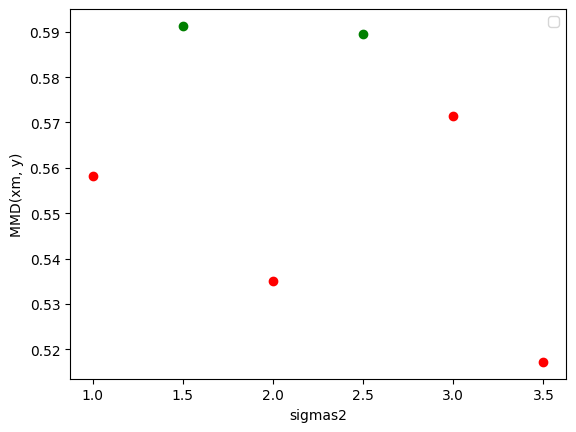

In [95]:
for _ in results.keys():
    print(results[_]["rnpe_mmd_h0"])
    plt.scatter(_, results[_]["rnpe_mmd_t0"], c='g' if results[_]["rnpe_mmd_h0"] else 'r')
plt.xlabel("sigmas2")
plt.ylabel("MMD(xm, y)")
plt.legend()